# Let's perform a basic sentiment analysis on user comments re: Tesla!

As an investor who likes excitement, I have duly invested in Tesla. 

And as an investor who likes more information, I am inclined to believe feelings on Tesla's product, its competitors' products, its people, and the company itself in aggregate could be a fickle facsimile for, for example, its stock price today and yesterday.

### 1. First we scrape reddit's subreddit for teslamotors! 
To this end, we use use much of __[Felippe Rodrigues' tutorial on praw](http://www.storybench.org/how-to-scrape-reddit-with-python/)__. We store our data in a pandas dataframe for  visualization and access.




In [1]:
import praw
import pandas as pd
import datetime as dt

In [2]:
#my credentials; username and password are optional for scraping public posts in read_only = True
reddit = praw.Reddit(client_id='', 
                     client_secret='', 
                     user_agent='')
print(reddit.read_only)

True


In [3]:
teslamotors_new = reddit.subreddit('teslamotors').new(limit = 100)
print(reddit.subreddit('teslamotors').title)

topics_dict = { "title":[], 
                "score":[], 
                "id":[], 
                "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[]}

for submission in teslamotors_new:
    topics_dict["title"].append(submission.title)
    topics_dict["score"].append(submission.score)
    topics_dict["id"].append(submission.id)
    topics_dict["url"].append(submission.url)
    topics_dict["comms_num"].append(submission.num_comments)
    topics_dict["created"].append(submission.created)
    topics_dict["body"].append(submission.selftext)

Tesla, Inc - The Original Tesla Motors Reddit Forum


In [4]:
topics_data = pd.DataFrame(topics_dict)
def get_date(utctime): #turn reddit time into readable UTC time in timestamp column
    return dt.datetime.fromtimestamp(utctime)
_timestamp = topics_data["created"].apply(get_date) #applies function get_date to the array topics_data["created"]
topics_data = topics_data.assign(timestamp = _timestamp)
topics_data.head(3)

,title,score,id,url,comms_num,created,body,timestamp
0,Fremont police Tesla runs low on juice in high...,0,d8wp1j,https://www.eastbaytimes.com/2019/09/24/fremon...,13,1.569405e+09,,2019-09-25 04:47:31
1,Performance vs Long-Range (Price diff; $5682),11,d8w8ds,https://www.reddit.com/r/teslamotors/comments/...,46,1.569402e+09,"Hi all,\n\nI know there have been multiple dis...",2019-09-25 04:02:01
2,Tesla is building a major engineering team in ...,57,d8un7f,https://www.reddit.com/r/teslamotors/comments/...,14,1.569393e+09,[Teslarati](https://twitter.com/Teslarati/stat...,2019-09-25 01:37:21


### 2. Find the polarities of comments, split by yesterday and today

We take posts in the new 100 threads of the subreddit and split them up by threads made today and made yesterday. In threads made yesterday and likewise for today, we take all posts and apply textblob natural language processing to obtain polarities for each post. We also store noun phrases that were used in an arbitrarily negative-enough or positive-enough post.

In [5]:
from textblob import TextBlob
from profanity import profanity

today = dt.date.today()
print("day of the month today:", today.day) 
print("yesterday:", today.day-1) #will not work properly if today is the first of the month

polarities = {'today':[],'yesterday':[]}
subjectivity = {'today':[],'yesterday':[]}
positive_polarities_nouns = {'today':[],'yesterday':[]}
negative_polarities_nouns = {'today':[],'yesterday':[]}


for index in topics_data.index: #we go through the entire pandas panel
        submission = reddit.submission(id = topics_data['id'][index]) #create the reddit object for every thread
        submission.comments.replace_more(limit = None) #enumerate every comment in thread
        for comment in submission.comments.list(): 
            comment_blob = TextBlob(comment.body)
            if topics_data['timestamp'][index].day==today.day:  #was it today?
                polarities['today'].append(comment_blob.polarity) # we append the score of the entire comment
                subjectivity['today'].append(comment_blob.subjectivity)
                for ele in comment_blob.noun_phrases:
                    if comment_blob.polarity < -0.25: # only nouns in comments more negative than -.25 are recorded
                        negative_polarities_nouns['today'].append(profanity.censor(ele))
                    elif comment_blob.polarity > 0.25:
                        positive_polarities_nouns['today'].append(profanity.censor(ele))
                    
            if topics_data['timestamp'][index].day==today.day-1: #was it yesterday?
                polarities['yesterday'].append(comment_blob.polarity)
                subjectivity['yesterday'].append(comment_blob.subjectivity) 
                for ele in comment_blob.noun_phrases:
                    if comment_blob.polarity < -0.25:
                        negative_polarities_nouns['yesterday'].append(profanity.censor(ele))
                    elif comment_blob.polarity > 0.25:
                        positive_polarities_nouns['yesterday'].append(profanity.censor(ele))

day of the month today: 24
yesterday: 23


### 3. Plot the distribution of polarities in comments, split by yesterday and today

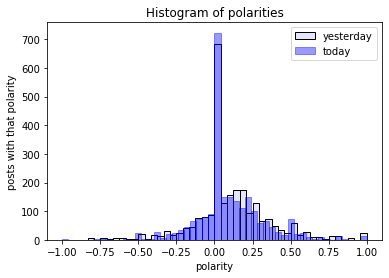

average polarity yesterday: 0.10614284245681165
average polarity today: 0.08820001245407855
Posts today have been more negative than yesterday on average.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean 

plt.hist(polarities['yesterday'], label= 'yesterday', color = 'lavender', bins=48, edgecolor = 'black')
sns.distplot(polarities['today'], label = 'today', hist = True, 
             kde = False, color = 'blue', hist_kws={'edgecolor':'blue'})
plt.legend()
plt.title('Histogram of polarities')
plt.xlabel('polarity')
plt.ylabel('posts with that polarity')
plt.show()

print("average polarity yesterday:", mean(polarities['yesterday']))
print("average polarity today:", mean(polarities['today']))
if mean(polarities['today']) > mean(polarities['yesterday']):
    print("Posts today have been more positive than yesterday on average!") 
else:
    print("Posts today have been more negative than yesterday on average.")

### 4. Create wordclouds to roughly apprise what nouns, respectively, the positive and negative comments involve themselves with! Higher frequency words are shown by larger words.

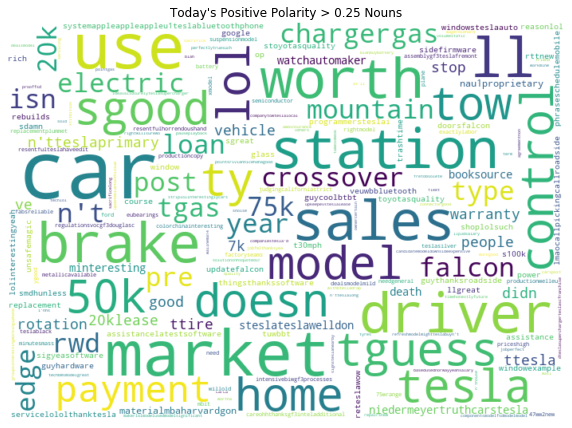

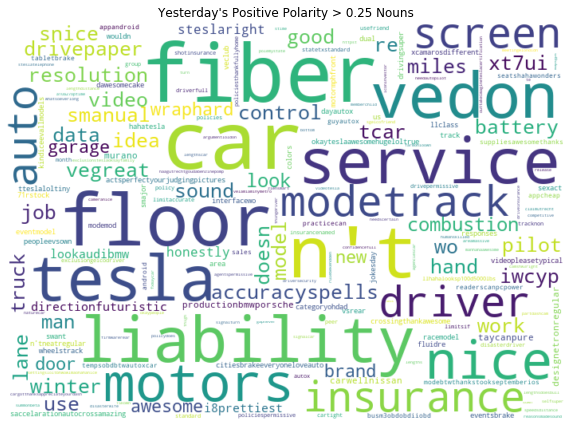

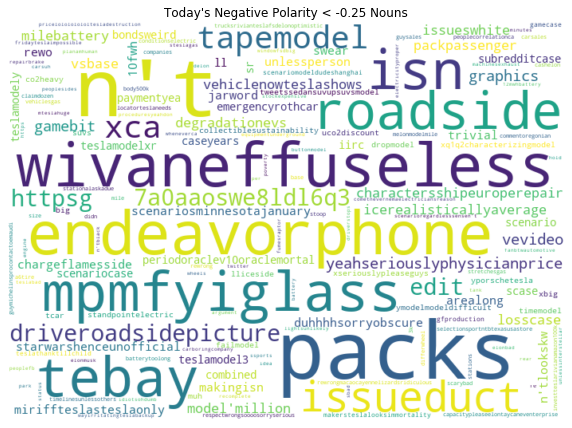

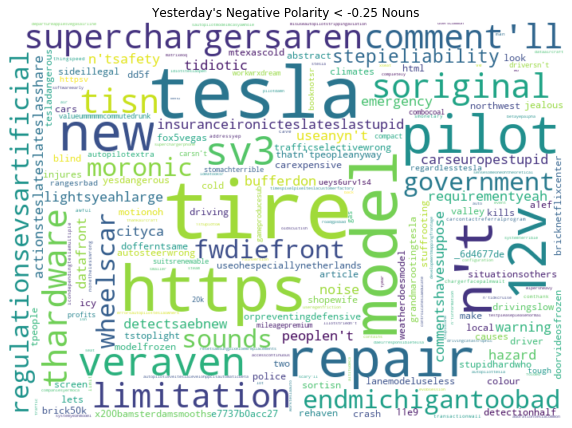

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


wordcloud = WordCloud(collocations=False, max_font_size=100, width=700, height=500, background_color='white').generate("".join(positive_polarities_nouns['today']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Today's Positive Polarity > 0.25 Nouns")
plt.show()

wordcloud = WordCloud(collocations=False, max_font_size=100, width=700, height=500, background_color='white').generate("".join(positive_polarities_nouns['yesterday']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Yesterday's Positive Polarity > 0.25 Nouns")
plt.show()

wordcloud = WordCloud(collocations=False, max_font_size=100, width=700, height=500, background_color='white').generate("".join(negative_polarities_nouns['today']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Today's Negative Polarity < -0.25 Nouns")
plt.show()

wordcloud = WordCloud(collocations=False, max_font_size=100, width=700, height=500, background_color='white').generate("".join(negative_polarities_nouns['yesterday']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Yesterday's Negative Polarity < -0.25 Nouns")
plt.show()

This project was heavily inspired by my previous work as a MBA student-consultant performing marketing analysis. Insofar Web 3.0 develops, this may help many other business roles.